# Exercise: Geographical Cluster Analysis of Taxi Rides
Using the NY Taxi data set (see Use Case Block I) and the use case from the lecture...

In [1]:
import pandas as pd
import numpy as np
import folium


In [2]:
# we load the data we have saved after wrangling and pre-processing in block I
train=pd.read_csv('../../DATA/train_cleaned.csv')

In [3]:
#select only the culumns with the ride coordinates
coordinates = train[ ['pickup_latitude','pickup_longitude','dropoff_latitude' , 'dropoff_longitude' ] ]

## Clustering approach from the lecture
we will be using simple K-Means:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [4]:
from sklearn.cluster import KMeans

In [5]:
#define number of clusters and create instance
clusters=100
myKMeans=KMeans(n_clusters=clusters, n_jobs=-1)#parallelize to all cores

In [6]:
%%time
#train model
myKMeans.fit(coordinates.to_numpy()[:100000,:])#use only subset of the data to make it faster

c:\users\lutz\documents\github\datascience21\block_4\venv\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Wall time: 42.1 s


KMeans(n_clusters=100, n_jobs=-1)

In [7]:
#get cluster centers
centers=myKMeans.cluster_centers_
    

In [8]:
#draw map: green: start, red: end
cluster_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
for i in range(clusters):
    folium.CircleMarker([centers[i,0], centers[i,1]], radius=3,                
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(cluster_map)
    folium.CircleMarker([centers[i,2], centers[i,3]], radius=3,                
                        color="red", 
                        fill_opacity=0.9
                       ).add_to(cluster_map)
    folium.PolyLine([ [centers[i,0],centers[i,1]] , [centers[i,2],centers[i,3]]  ], color="black", weight=2.5, opacity=1).add_to(cluster_map)

In [9]:
cluster_map

## Exercise 1
Write a function ```show_cluster(cluster_number,...)``` that draws the cluster centers and all start and end points of a given cluster in the map.
* use the ```predict()``` method to map all data in ```train_data``` to a cluster center
* use ```folium.CircleMarker``` to draw all members of a given cluster


In [10]:
pred_coordinates = train[ ['pickup_latitude','pickup_longitude','dropoff_latitude' , 'dropoff_longitude' ] ]
pred = myKMeans.predict(pred_coordinates)

In [11]:
map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)

In [12]:
def show_cluster(cluster_number, member_color='#3F51B5', center_color='#FFEE58'):
    # filter out the cluster
    cluster_mask = pred == cluster_number
    cords = pred_coordinates[cluster_mask]
    # draw each row
    for index, row in cords.iterrows():
        folium.CircleMarker([row[0], row[1]], radius=3,
                            color=member_color,
                            fill_opacity=0.9
                           ).add_to(map)
        folium.CircleMarker([row[2], row[3]], radius=3,
                            color=member_color,
                            fill_opacity=0.9
                           ).add_to(map)
    # draw the center
    folium.CircleMarker([centers[cluster_number,0], centers[cluster_number,1]], radius=10,
                        color=center_color,
                        fill_color = center_color,
                        fill_opacity=0.2
                       ).add_to(map)
    folium.CircleMarker([centers[cluster_number,2], centers[cluster_number,3]], radius=10,
                        color=center_color,
                        fill_color = center_color,
                        fill_opacity=0.2,
                       ).add_to(map)

In [13]:
show_cluster(26)
map

## Exercise 2
Write a function ```cluster_var(cluster_number,...)``` that computes the intra- and extra cluster variance for a given cluster. Apply it to all clusters and compare the results for k=100 and k=10.

In [14]:
k2=10
kmeans_2=KMeans(n_clusters=k2, n_jobs=-1)#parallel
kmeans_2.fit(coordinates.to_numpy()[:100000,:])
pred_2 = kmeans_2.predict(pred_coordinates)
centers_2=myKMeans.cluster_centers_

c:\users\lutz\documents\github\datascience21\block_4\venv\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


In [15]:
def cluster_var(cluster_number, cluster_count, prediction, centers):
    cluster_mask = prediction == cluster_number
    center_start_point = np.array((centers[cluster_number,0], centers[cluster_number,1]))
    center_end_poinnt = np.array((centers[cluster_number,2], centers[cluster_number,3]))
    cords = pred_coordinates[cluster_mask]
    # intra cluster distance
    intra_distances = []
    for index, row in cords.iterrows():
        point_start = np.array((row[0], row[1]))
        point_end = np.array((row[2], row[3]))
        start_dist = np.linalg.norm(point_start - center_start_point)
        end_dist = np.linalg.norm(point_end - center_end_poinnt)
        intra_distances.append(start_dist)
        intra_distances.append(end_dist)
    intra_cluster_distance = np.mean(intra_distances)
    # extra distance
    center_distances = []
    for i in range(cluster_count):
        if i == cluster_number:
            continue
        target_start_center = np.array((centers[i,0], centers[i,1]))
        target_end_center = np.array((centers[i,2], centers[i,3]))
        start_dist = np.linalg.norm(target_start_center - center_start_point)
        end_dist = np.linalg.norm(target_end_center - center_end_poinnt)
        center_distances.append(start_dist)
        center_distances.append(end_dist)
    extra_cluster_distance = np.mean(center_distances)
    return intra_cluster_distance, extra_cluster_distance

In [16]:
intra_cluster_distances = []
extra_cluster_distances = []
for i in range(k2):
    intra_cluster_distance, extra_cluster_distance = cluster_var(i, k2, pred_2, centers_2)
    intra_cluster_distances.append(intra_cluster_distance)
    extra_cluster_distances.append(extra_cluster_distance)

<BarContainer object of 10 artists>

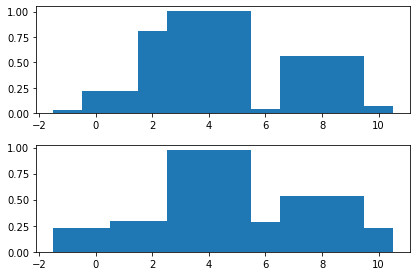

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2, 1)
fig.tight_layout()
x = np.arange(len(intra_cluster_distances))
axes[0].bar(x, intra_cluster_distances, 3)
x2 = np.arange(len(extra_cluster_distances))
axes[1].bar(x2, extra_cluster_distances, 3)

Die Intra Cluster Distanz zeigt eine unaugeglichene Größe der Cluster. Cluster 1-3 und 10 sind sehr klein. Cluster
4-9 sind dagegen relativ groß. Die Extra Cluster Distanz zeigt, dass Cluster 4,5,6 sehr weit von den anderen
Clustern entfernt liegt. Die anderen liegen relativ nahe beieinander.

In [18]:
intra_cluster_distances = []
extra_cluster_distances = []
for i in range(clusters):
    intra_cluster_distance, extra_cluster_distance = cluster_var(i, clusters, pred, centers)
    intra_cluster_distances.append(intra_cluster_distance)
    extra_cluster_distances.append(extra_cluster_distance)

<BarContainer object of 100 artists>

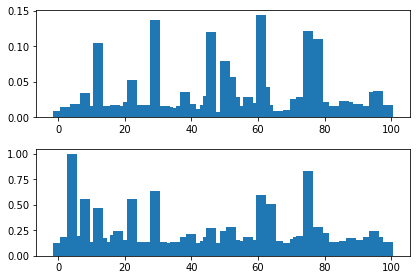

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2, 1)
fig.tight_layout()
x = np.arange(len(intra_cluster_distances))
axes[0].bar(x, intra_cluster_distances, 3)
x2 = np.arange(len(extra_cluster_distances))
axes[1].bar(x2, extra_cluster_distances, 3)

Die Intra und Extra Cluster Distanz ist breiter gestreut als bei dem Modell mit nur 10
Clustern. Die Intra Cluster Distanz ist sehr viel geringer als bei 10 Clustern. Die Extra
Cluster Distanz ist ähnlich.